In [8]:
#!/usr/bin/python
import torch
import os
import pandas as pd
import yaml
import scipy.io as sio
import json

from deeplab3.dataloaders import make_data_loader
from deeplab3.config.defaults import get_cfg_defaults
from deeplab3.test import Tester

In [2]:
# traverse root directory, and list directories as dirs and files as files
model_configs = []
for root, dirs, files in os.walk("../run/"):
    path = root.split(os.sep)
    for file in files:
        if file == "parameters.txt.yaml" or file=="parameters.yaml":
            model_configs.append(os.path.join(root, file))
print(model_configs)

['../run/older/coco_rgb_resnet_scratch/2020_04_10/parameters.txt.yaml', '../run/older/coco_rgb_resnet_scratch/2020-03-29/parameters.txt.yaml', '../run/older/cityscapes_hha_midfusion_pretrained/2020_04_06/parameters.txt.yaml', '../run/older/cityscapes_rgbd_resnet_deeplab/2020-03-30/parameters.txt.yaml', '../run/older/cityscapes_rgbd_resnet_deeplab/2020-03-30c/parameters.txt.yaml', '../run/older/cityscapes_rgbd_resnet_deeplab/2020_04_06/parameters.txt.yaml', '../run/older/cityscapes_synth_rgbd_xception_fine_coarse/2020_04_25-14_32_21/parameters.txt.yaml', '../run/older/cityscapes_rgbd_xception_fine_coarse/2020_04_28-01_42_47/parameters.txt.yaml', '../run/older/cityscapes_synthetic/2020_04_10/parameters.txt.yaml', '../run/older/cityscapes_synthetic/2020-03-30b/parameters.txt.yaml', '../run/older/cityscapes_rgbd_xception_fine/2020_04_26-20_04_07/parameters.txt.yaml', '../run/older/cityscapes_hha_midfusion/2020_04_16/parameters.txt.yaml', '../run/older/cityscapes_synth_rgbd_xception_fine/20

In [3]:
len(model_configs)

80

In [4]:
def flatten_cfg(cfg_dict, prefix=None):
    flattened = {}
    for key, value in cfg_dict.items():
        if prefix is None:
            prefixed_key = key
        else:
            prefixed_key = "{}.{}".format(prefix, key)
            
        if not isinstance(value, dict):
            flattened[prefixed_key] = value
        else:
            flattened.update(flatten_cfg(value, prefixed_key))
    return flattened

In [5]:
def match_cfg_versions(cfg_filepath):
    cfg = get_cfg_defaults()
    with open(cfg_filepath, 'r') as f:
        model_cfg = yaml.load(f)
        model_cfg = flatten_cfg(model_cfg)
    for key, value in model_cfg.items():
        if not key.startswith("CHECKPOINT"):
            try:
                if key == "TRAIN.EVAL_INTERVAL":
                    value = float(value)
                if key == "DATASET.USE_DEPTH":
                    key = "DATASET.MODE"
                    if value:
                        value = "RGBD"
                    else:
                        value = "RGB"
                if key == "DATASET.CHANNELS":
                    key = "MODEL.INPUT_CHANNELS"

                cfg.merge_from_list([key, value])
            except ValueError as e:
                print(e)
            except AssertionError as e:
                print(e)

    if cfg.DATASET.ROOT.startswith("datasets"):
        cfg.merge_from_list(['DATASET.ROOT', "../" + cfg.DATASET.ROOT])
    if cfg.DATASET.NAME == "sunrgbd":
        cfg.DATASET.ROOT = "../datasets/SUNRGBD/"
    elif cfg.DATASET.NAME == "scenenet":
        cfg.DATASET.ROOT = "../datasets/scenenet/"

    return cfg

In [6]:
def test_model(cfg):
    torch.manual_seed(cfg.SYSTEM.SEED)
    train_loader, val_loader, test_loader, num_classes = make_data_loader(cfg)
    tester = Tester(cfg)
    output, mat, metrics = tester.run(val_loader, num_classes)

    with open(cfg.CHECKPOINT.DIRECTORY + '/validation_report.txt', 'w') as f:
        f.write(output)

    sio.savemat(cfg.CHECKPOINT.DIRECTORY + '/confusion.mat', {'confusion': mat})
    
    return metrics

In [7]:
failed = []
model_output = {}

for cfg_filepath in model_configs:
    try:
        cfg = match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                            'MODEL.PRETRAINED', "",
                            'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
        checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))
        
        model_output[cfg_filepath] = {'dataset': cfg.DATASET.NAME,
                                         'model': cfg.MODEL.NAME,
                                         'image_type': cfg.DATASET.MODE,
                                         'low_light': str(cfg.DATASET.DARKEN),
                                         'epoch': checkpoint['epoch']}
        
        result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'validation_report.txt')
        checkpoint_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'checkpoint.pth.tar')
        if os.path.exists(result_file) and (os.path.getmtime(result_file) > os.path.getmtime(checkpoint_file)):
            with open(result_file, 'r') as fp:
                metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                metrics = json.loads('{' + metric_str + '}')
        else:
            #failed.append(cfg_filepath)
            metrics = test_model(cfg)

        model_output[cfg_filepath].update(metrics)
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)
        
    
        

<ipython-input-5-1b49db3f950b>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  model_cfg = yaml.load(f)


Non-existent key: RESUME.DIRECTORY
Non-existent key: RESUME.MODEL
Non-existent key: TRAIN.LR_SCHEDULER
Non-existent key: TRAIN.MOMENTUM
Non-existent key: TRAIN.NESTROV
Non-existent key: TRAIN.RESUME
Non-existent key: TRAIN.WEIGHT_DECAY
Non-existent key: DATASET.CITYSCAPES.SYNTHETIC_DEPTH
Non-existent key: RESUME.DIRECTORY
Non-existent key: RESUME.MODEL
Non-existent key: TRAIN.LR_SCHEDULER
Non-existent key: TRAIN.MOMENTUM
Non-existent key: TRAIN.NESTROV
Non-existent key: TRAIN.RESUME
Non-existent key: TRAIN.WEIGHT_DECAY
Non-existent key: RESUME.DIRECTORY
Non-existent key: RESUME.MODEL
Non-existent key: TRAIN.LR_SCHEDULER
Non-existent key: TRAIN.MOMENTUM
Non-existent key: TRAIN.NESTROV
Non-existent key: TRAIN.RESUME
Non-existent key: TRAIN.WEIGHT_DECAY
Non-existent key: DATASET.CITYSCAPES.SYNTHETIC_DEPTH
Non-existent key: RESUME.DIRECTORY
Non-existent key: RESUME.MODEL
Non-existent key: TRAIN.LR_SCHEDULER
Non-existent key: TRAIN.MOMENTUM
Non-existent key: TRAIN.NESTROV
Non-existent key: 

:   0%|          | 0/1000 [00:00<?, ?it/s]

=> loaded checkpoint '../run/scenenet/scenenet_depthaware/2020_09_25-18_24_55/checkpoint.pth.tar' (epoch 2)


Test loss: 0.121:   0%|          | 0/1000 [00:00<?, ?it/s]/home/cecilia/pytorch-deeplab-xception/deeplab3/evaluators/segmentation_evaluator.py:89: RuntimeWarning: invalid value encountered in true_divide
  MIoU = np.diag(confusion_matrix) / (
/home/cecilia/pytorch-deeplab-xception/deeplab3/evaluators/segmentation_evaluator.py:104: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(confusion_matrix) / (
Test loss: 0.228: 100%|██████████| 1000/1000 [10:30<00:00,  1.59it/s]


Non-existent key: DATASET.CITYSCAPES.TEST_SET
[Errno 2] No such file or directory: '../run/scenenet/scenenet_depthaware/2020_09_17-09_48_41/checkpoint.pth.tar'
../run/scenenet/scenenet_depthaware/2020_09_17-09_48_41/parameters.yaml
[Errno 2] No such file or directory: '../run/scenenet/scenenet_depthaware/2020_09_23-18_31_20/checkpoint.pth.tar'
../run/scenenet/scenenet_depthaware/2020_09_23-18_31_20/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB input
Found 292803 train images
Using RGB input
Found 291919 val images
Using RGB input
Found 293214 test images
Training backbone from scratch


:   0%|          | 0/1000 [00:00<?, ?it/s]

=> loaded checkpoint '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/checkpoint.pth.tar' (epoch 5)


Test loss: 0.226: 100%|██████████| 1000/1000 [18:00<00:00,  1.08s/it]


Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB-D input
Found 292803 train images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 293214 test images
Training backbone from scratch


:   0%|          | 0/1000 [00:00<?, ?it/s]

=> loaded checkpoint '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_32_05/checkpoint.pth.tar' (epoch 7)


Test loss: 0.218: 100%|██████████| 1000/1000 [21:50<00:00,  1.31s/it]


Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB HHA input
Found 19997 train_extra images
Using RGB HHA input
Found 500 val images
Using RGB HHA input
Found 1525 test images
Training backbone from scratch
Training backbone from scratch


:   0%|          | 0/125 [00:00<?, ?it/s]

=> loaded checkpoint '../run/cityscapes/cityscapes_hha_latefusion_scratch/2020_09_29-14_09_39/checkpoint.pth.tar' (epoch 35)


Test loss: 1.789: 100%|██████████| 125/125 [03:23<00:00,  1.62s/it]


Using RGB input
Found 19997 train_extra images
Using RGB input
Found 500 val images
Using RGB input
Found 1525 test images
Training backbone from scratch


:   0%|          | 0/125 [00:00<?, ?it/s]

=> loaded checkpoint '../run/cityscapes/cityscapes_rgb_xception_scenenet/2020_09_25-22_09_12/checkpoint.pth.tar' (epoch 158)


Test loss: 0.076: 100%|██████████| 125/125 [02:07<00:00,  1.02s/it]


Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB HHA input
Found 19997 train_extra images
Using RGB HHA input
Found 500 val images
Using RGB HHA input
Found 1525 test images
Loading pretrained ResNet model: https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
Loading pretrained ResNet model: https://download.pytorch.org/models/resnet101-5d3b4d8f.pth


:   0%|          | 0/125 [00:00<?, ?it/s]

=> loaded checkpoint '../run/cityscapes/cityscapes_hha_midfusion/2020_09_29-03_29_42/checkpoint.pth.tar' (epoch 47)


Test loss: 1.298: 100%|██████████| 125/125 [03:22<00:00,  1.62s/it]


Using RGB HHA input
Found 19997 train_extra images
Using RGB HHA input
Found 500 val images
Using RGB HHA input
Found 1525 test images
Training backbone from scratch
Training backbone from scratch


:   0%|          | 0/125 [00:00<?, ?it/s]

=> loaded checkpoint '../run/cityscapes/cityscapes_hha_midfusion_scratch/2020_09_29-03_32_00/checkpoint.pth.tar' (epoch 47)


Test loss: 1.228: 100%|██████████| 125/125 [03:33<00:00,  1.71s/it]


Non-existent key: DATASET.CITYSCAPES.TEST_SET
while scanning for the next token
found character '\t' that cannot start any token
  in "../run/cityscapes/cityscapes_rgbd_resnet_coco_fine/2020_08_05-18_17_41/parameters.yaml", line 34, column 3
../run/cityscapes/cityscapes_rgbd_resnet_coco_fine/2020_08_05-18_17_41/parameters.yaml
Using RGB HHA input
Found 19997 train_extra images
Using RGB HHA input
Found 500 val images
Using RGB HHA input
Found 1525 test images
Loading pretrained ResNet model: https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
Loading pretrained ResNet model: https://download.pytorch.org/models/resnet101-5d3b4d8f.pth


:   0%|          | 0/125 [00:00<?, ?it/s]

=> loaded checkpoint '../run/cityscapes/cityscapes_hha_latefusion/2020_09_29-03_32_23/checkpoint.pth.tar' (epoch 48)


Test loss: 0.665: 100%|██████████| 125/125 [03:24<00:00,  1.64s/it]


Using RGB input
Found 19997 train_extra images
Using RGB input
Found 500 val images
Using RGB input
Found 1525 test images
Training backbone from scratch


:   0%|          | 0/125 [00:00<?, ?it/s]

=> loaded checkpoint '../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/checkpoint.pth.tar' (epoch 59)


Test loss: 0.097: 100%|██████████| 125/125 [03:31<00:00,  1.69s/it]


Non-existent key: DATASET.CITYSCAPES.TEST_SET
loading annotations into memory...
Done (t=17.51s)
creating index...
index created!
Using RGB input
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Using RGB input
Training backbone from scratch


:   0%|          | 0/973 [00:00<?, ?it/s]

=> loaded checkpoint '../run/coco/coco_rgb_xception_scenenet/2020_09_25-22_18_33/checkpoint.pth.tar' (epoch 27)


Test loss: 0.267: 100%|██████████| 973/973 [18:09<00:00,  1.12s/it]


[Errno 2] No such file or directory: '../run/coco/coco_rgbd_pascal_low_light/2020_09_23-15_59_09/checkpoint.pth.tar'
../run/coco/coco_rgbd_pascal_low_light/2020_09_23-15_59_09/parameters.yaml
[Errno 2] No such file or directory: '../run/coco/coco_rgbd_pascal_low_light/2020_09_23-16_36_15/checkpoint.pth.tar'
../run/coco/coco_rgbd_pascal_low_light/2020_09_23-16_36_15/parameters.yaml
loading annotations into memory...
Done (t=15.15s)
creating index...
index created!
Using RGB-D input
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Using RGB-D input
Training backbone from scratch


:   0%|          | 0/973 [00:00<?, ?it/s]

=> loaded checkpoint '../run/coco/coco_rgbd_xception/2020_09_25-19_45_43/checkpoint.pth.tar' (epoch 26)


Test loss: 0.176: 100%|██████████| 973/973 [21:37<00:00,  1.33s/it]


Non-existent key: DATASET.CITYSCAPES.TEST_SET
[Errno 2] No such file or directory: '../run/coco/coco_rgb_xception/2020_09_25-21_42_15/checkpoint.pth.tar'
../run/coco/coco_rgb_xception/2020_09_25-21_42_15/parameters.yaml


In [9]:
print("\n".join(failed))
model_configs = failed

../run/scenenet/scenenet_depthaware/2020_09_17-09_48_41/parameters.yaml
../run/scenenet/scenenet_depthaware/2020_09_23-18_31_20/parameters.yaml
../run/cityscapes/cityscapes_rgbd_resnet_coco_fine/2020_08_05-18_17_41/parameters.yaml
../run/coco/coco_rgbd_pascal_low_light/2020_09_23-15_59_09/parameters.yaml
../run/coco/coco_rgbd_pascal_low_light/2020_09_23-16_36_15/parameters.yaml
../run/coco/coco_rgb_xception/2020_09_25-21_42_15/parameters.yaml


In [10]:
model_output
    

{'../run/older/coco_rgb_resnet_scratch/2020_04_10/parameters.txt.yaml': {'dataset': 'coco',
  'model': 'deeplab',
  'image_type': 'RGB',
  'low_light': 'False',
  'epoch': 49,
  'Acc': 0.8435164421288402,
  'Acc_class': 0.4824342349065253,
  'mIoU': 0.3595463132615395,
  'FWIoU': 0.7440447055212059},
 '../run/older/coco_rgb_resnet_scratch/2020-03-29/parameters.txt.yaml': {'dataset': 'coco',
  'model': 'deeplab',
  'image_type': 'RGB',
  'low_light': 'False',
  'epoch': 45,
  'Acc': 0.8390265130093377,
  'Acc_class': 0.4903644343712708,
  'mIoU': 0.36058857881851786,
  'FWIoU': 0.740611087877224},
 '../run/older/cityscapes_hha_midfusion_pretrained/2020_04_06/parameters.txt.yaml': {'dataset': 'cityscapes',
  'model': 'midfusion',
  'image_type': 'RGB_HHA',
  'low_light': 'False',
  'epoch': 77,
  'Acc': 0.5902988041735154,
  'Acc_class': 0.28860781674638136,
  'mIoU': 0.17119790640454474,
  'FWIoU': 0.4601601657506956},
 '../run/older/cityscapes_rgbd_resnet_deeplab/2020-03-30/parameters.

In [11]:
from collections import defaultdict

def plot_comparison(dataset='cityscapes', low_light='False'):
    best = defaultdict(lambda: defaultdict(dict))
    for key, value in model_output.items():
        if value['low_light']==low_light:
            model = "/".join(key.split('/')[3:5])
            model = '{}({})'.format(model, value['epoch'])
            if model in best[value['dataset']][value['image_type']]:
                compare_to = best[value['dataset']][value['image_type']][model]

                if value['mIoU'] > compare_to:
                    compare_to = value['mIoU']
            else:
                best[value['dataset']][value['image_type']][model] = value['mIoU']

    df = pd.DataFrame(best[dataset])
    column_names = df.columns.values.tolist()
    column_names.sort()  # Make sure all the colors are in the same order 
    df = df.sort_values(column_names)
    
    color=['red', 'green', 'blue']
    color_dict = dict(zip(column_names, color[:len(column_names)]))
    ax = df.plot(kind='barh', figsize=(12,8), color=color_dict)
    for p in ax.patches:
        if p.get_width() > 0 :
            ax.annotate("{:2.2}".format(p.get_width()), (p.get_width() * 1.005, p.get_y() * 1.005))

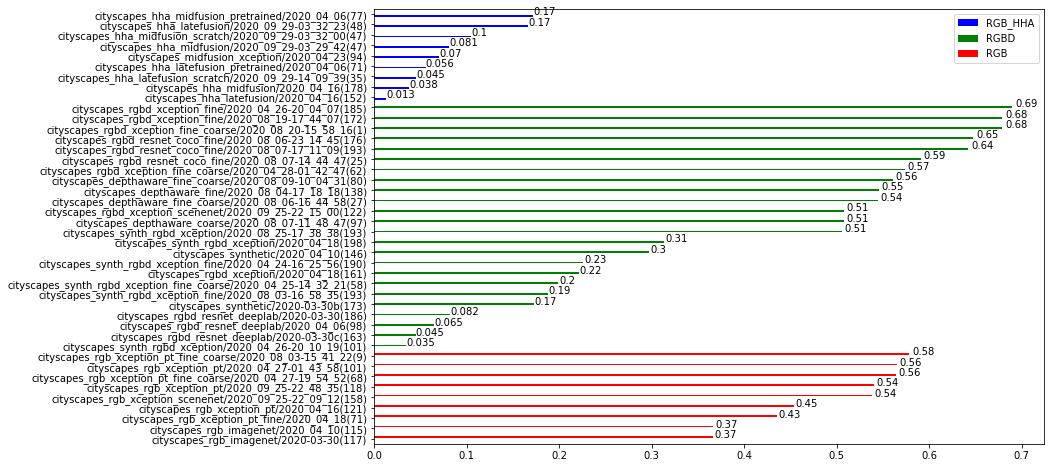

In [12]:
plot_comparison()

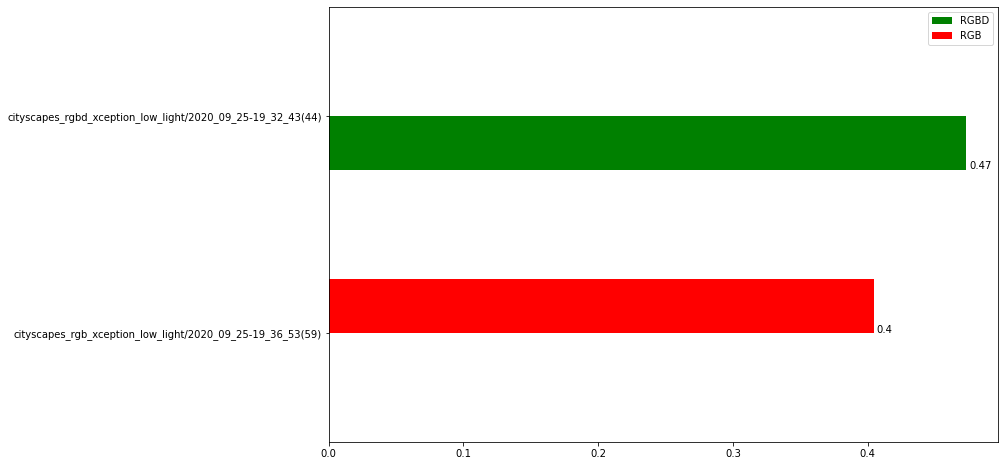

In [13]:
plot_comparison(low_light='True')

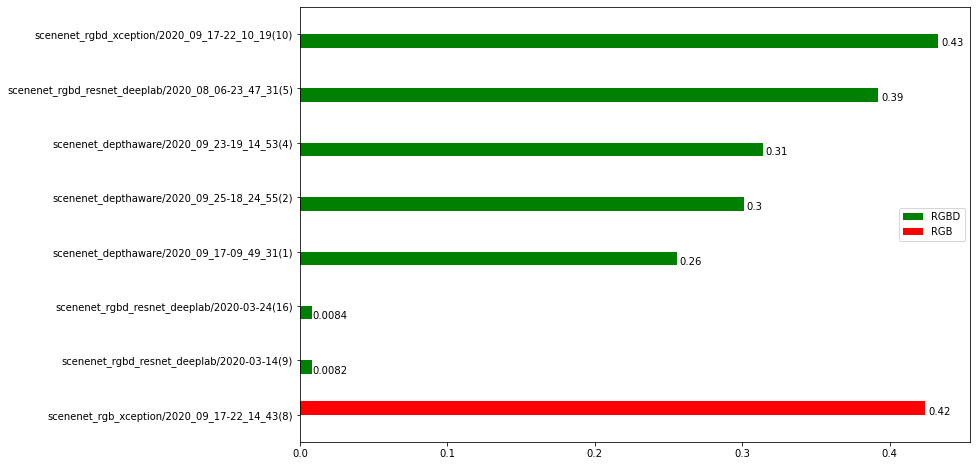

In [14]:
plot_comparison(dataset='scenenet')

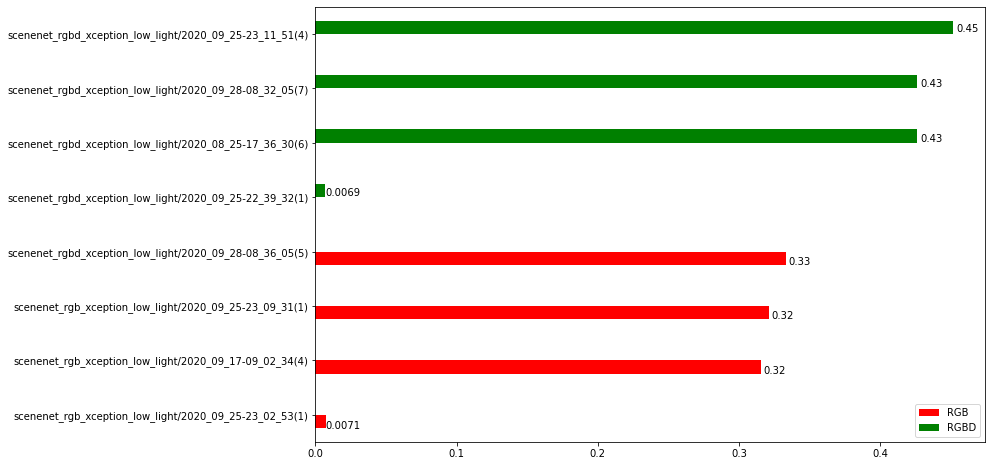

In [15]:
plot_comparison(dataset='scenenet', low_light='True')

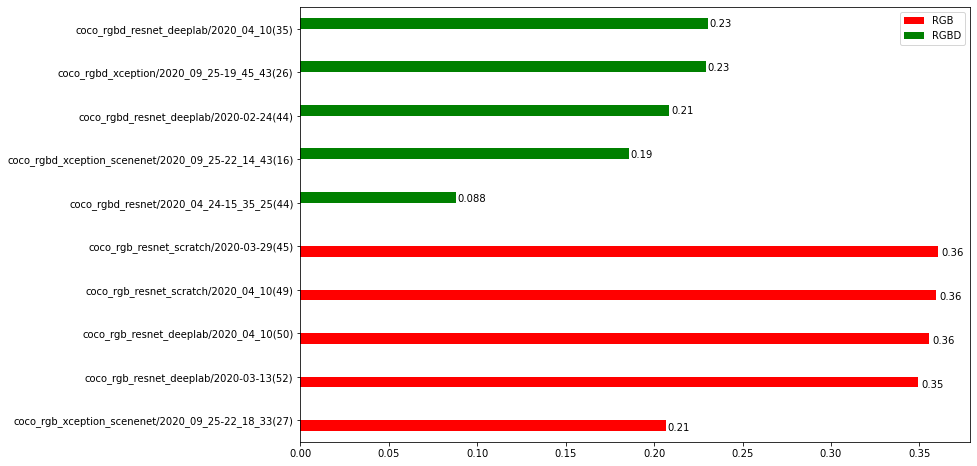

In [16]:
plot_comparison(dataset='coco')

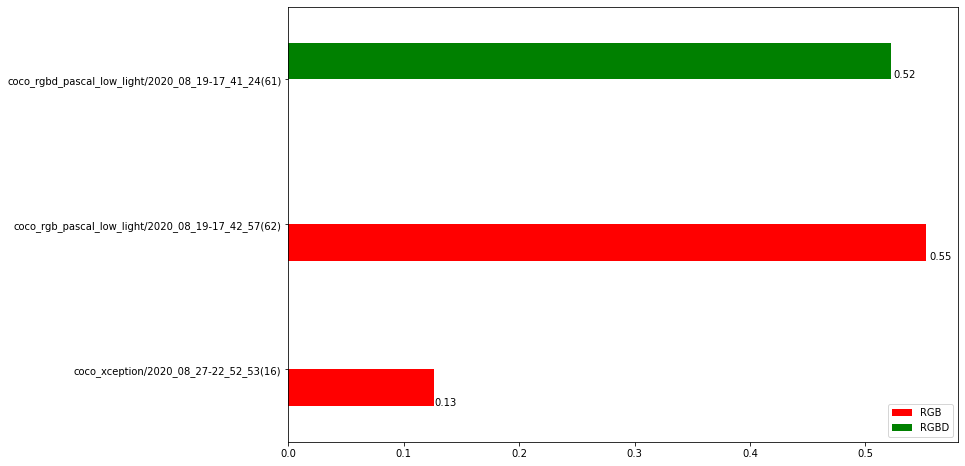

In [17]:
plot_comparison(dataset='coco', low_light='True')